# Land Survey Calculator
## Area Calculation using Shoelace and DMD Methods

This notebook provides a **completely self-contained** interface for calculating land survey areas using two independent methods:
- **Shoelace Formula** (Surveyor's Formula)
- **DMD Method** (Double Meridian Distance)

### Features:
1. **No External Dependencies** - All formulas embedded directly in this notebook
2. **Multiple Data Input Options** - CSV, Excel, or paste data directly
3. **Dual Calculation Methods** - Independent verification using both Shoelace and DMD
4. **Comprehensive Analysis** - Closure analysis, precision metrics, quality assessment
5. **Visual Comparison** - Charts comparing both methods

### Workflow:
1. Run all cells in order (Cell → Run All)
2. Choose your data input method (CSV, Excel, or paste directly)
3. Enter lot name when prompted
4. Review results and visualizations


## 1. Install Dependencies

**What this does:**
- Checks if required Python packages are installed
- Automatically installs missing packages
- Required: pandas, matplotlib, openpyxl, numpy

In [1]:
import subprocess
import sys

packages = ['pandas', 'matplotlib', 'openpyxl', 'numpy']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])

print('✓ All dependencies installed')

✓ All dependencies installed


## 2. Import Libraries

**What this does:**
- Imports core Python libraries for data processing and visualization
- No external survey modules required - all formulas are embedded below

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import math
import re
from typing import List, Tuple, Optional, Dict
from dataclasses import dataclass

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 3. Shared Utilities and Data Classes

**What this does:**
- Defines custom exceptions for error handling
- Creates data classes for Points, TraverseLines, and ClosureAnalysis
- Implements bearing to azimuth conversion
- Provides unit converters (m² ↔ hectares, acres, ft²)
- Includes quality metrics for precision assessment

In [3]:
# ============================================================================
# CUSTOM EXCEPTIONS
# ============================================================================

class SurveyException(Exception):
    """Base exception for survey calculation errors"""
    pass

class BearingFormatError(SurveyException):
    """Raised when bearing format is invalid"""
    pass

class ValidationError(SurveyException):
    """Raised when input validation fails"""
    pass

# ============================================================================
# DATA CLASSES
# ============================================================================

@dataclass
class Point:
    """Represents a 2D point in a coordinate system"""
    x: float
    y: float
    label: str = ""

    def distance_to(self, other: 'Point') -> float:
        """Calculate Euclidean distance to another point"""
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

@dataclass
class TraverseLine:
    """Represents a survey traverse line"""
    bearing: str
    distance: float
    azimuth: Optional[float] = None

@dataclass
class ClosureAnalysis:
    """Results of traverse closure analysis"""
    closure_error_x: float
    closure_error_y: float
    linear_error: float
    perimeter: float
    relative_precision: float

    def is_acceptable(self, standard: str = "general") -> bool:
        """
        Check if closure meets standards
        Args:
            standard: One of 'engineering', 'property', 'general', 'rough'
        """
        standards = {
            'engineering': 5000,
            'property': 3000,
            'general': 1000,
            'rough': 500
        }
        required = standards.get(standard, 1000)
        return self.relative_precision >= required

# ============================================================================
# BEARING CONVERSION
# ============================================================================

class BearingConverter:
    """Handles conversion between bearing and azimuth formats"""

    BEARING_PATTERN = re.compile(
        r'^([NS])\s+(\d{1,2})°(\d{1,2})\'\s+([EW])$'
    )

    @staticmethod
    def to_azimuth(bearing: str) -> float:
        """
        Convert bearing to azimuth
        Args:
            bearing: Bearing string (e.g., "S 45°30' E")
        Returns:
            Azimuth in decimal degrees (0-360)
        """
        match = BearingConverter.BEARING_PATTERN.match(bearing)

        if not match:
            raise BearingFormatError(
                f"Invalid bearing format: '{bearing}'. "
                f"Expected format: 'N/S DD°MM' E/W'"
            )

        quadrant1, degrees, minutes, quadrant2 = match.groups()

        # Validate degree and minute ranges
        deg = int(degrees)
        min_ = int(minutes)

        if deg > 90 or deg < 0:
            raise BearingFormatError(f"Degrees must be 0-90, got {deg}")
        if min_ > 59 or min_ < 0:
            raise BearingFormatError(f"Minutes must be 0-59, got {min_}")

        # Convert to decimal degrees
        decimal_angle = deg + min_ / 60.0

        # Convert to azimuth based on quadrant
        if quadrant1 == 'N' and quadrant2 == 'E':
            azimuth = decimal_angle
        elif quadrant1 == 'S' and quadrant2 == 'E':
            azimuth = 180 - decimal_angle
        elif quadrant1 == 'S' and quadrant2 == 'W':
            azimuth = 180 + decimal_angle
        elif quadrant1 == 'N' and quadrant2 == 'W':
            azimuth = 360 - decimal_angle
        else:
            raise BearingFormatError(f"Invalid quadrant combination")

        return azimuth

# ============================================================================
# UNIT CONVERSION UTILITIES
# ============================================================================

class UnitConverter:
    """Utilities for unit conversions"""

    # Conversion factors
    M2_TO_FT2 = 10.7639
    M2_TO_ACRE = 0.000247105
    M2_TO_HECTARE = 0.0001

    @staticmethod
    def sqm_to_acres(area_m2: float) -> float:
        """Convert square meters to acres"""
        return area_m2 * UnitConverter.M2_TO_ACRE

    @staticmethod
    def sqm_to_hectares(area_m2: float) -> float:
        """Convert square meters to hectares"""
        return area_m2 * UnitConverter.M2_TO_HECTARE

    @staticmethod
    def sqm_to_sqft(area_m2: float) -> float:
        """Convert square meters to square feet"""
        return area_m2 * UnitConverter.M2_TO_FT2

# ============================================================================
# QUALITY METRICS
# ============================================================================

class QualityMetrics:
    """Calculate and report survey quality metrics"""

    @staticmethod
    def get_precision_description(relative_precision: float) -> str:
        """Get descriptive text for precision ratio"""
        if relative_precision >= 5000:
            return "Engineering Grade (Excellent)"
        elif relative_precision >= 3000:
            return "Property Survey Grade (Good)"
        elif relative_precision >= 1000:
            return "General Survey Grade (Acceptable)"
        elif relative_precision >= 500:
            return "Rough Survey (Poor)"
        else:
            return "Unacceptable Precision"

    @staticmethod
    def get_closure_status(linear_error: float) -> str:
        """Get closure status based on error magnitude"""
        if linear_error < 0.01:
            return "Closed (Excellent)"
        elif linear_error < 0.1:
            return "Well Closed"
        elif linear_error < 1.0:
            return "Closed"
        elif linear_error < 5.0:
            return "Poorly Closed"
        else:
            return "Open/Not Closed"

print('✓ Shared utilities loaded')

✓ Shared utilities loaded


## 4. Shoelace Calculator

**What this does:**
- Implements the Shoelace formula (also called Surveyor's Formula)
- Calculates polygon area from bearings and distances
- Formula: Area = |∑(x_i × y_(i+1) - x_(i+1) × y_i)| / 2
- Performs closure analysis and quality assessment

In [4]:
class ShoelaceCalculator:
    """
    Calculate polygon area and properties using the Shoelace formula
    
    The Shoelace formula calculates the area of a polygon given its
    vertices using the cross-product method.
    """

    def __init__(self):
        self.lines: List[TraverseLine] = []
        self.points: List[Point] = []

    def add_line(self, bearing: str, distance: float) -> None:
        """
        Add a traverse line
        Args:
            bearing: Bearing string (e.g., "S 45°05' E")
            distance: Distance in meters
        """
        if distance <= 0:
            raise ValidationError(f"Distance must be positive, got {distance}")

        line = TraverseLine(bearing=bearing, distance=distance)
        line.azimuth = BearingConverter.to_azimuth(bearing)
        self.lines.append(line)

    def calculate_coordinates(self, start_x: float = 0.0, start_y: float = 0.0) -> List[Point]:
        """
        Calculate polygon vertices from traverse data
        Args:
            start_x: Starting X coordinate (Easting)
            start_y: Starting Y coordinate (Northing)
        Returns:
            List of Point objects representing vertices
        """
        if len(self.lines) < 3:
            raise ValidationError("Polygon must have at least 3 sides")

        self.points = []
        current_x, current_y = start_x, start_y

        # Add starting point
        self.points.append(Point(current_x, current_y, "1"))

        # Calculate each subsequent point
        for i, line in enumerate(self.lines, 1):
            azimuth_rad = math.radians(line.azimuth)

            # In surveying: x is East, y is North
            delta_x = line.distance * math.sin(azimuth_rad)
            delta_y = line.distance * math.cos(azimuth_rad)

            current_x += delta_x
            current_y += delta_y

            # Don't add the last point (should close to start)
            if i < len(self.lines):
                self.points.append(Point(current_x, current_y, str(i + 1)))

        # Store final calculated position for closure analysis
        self._final_x = current_x
        self._final_y = current_y

        return self.points

    def calculate_area(self) -> float:
        """
        Calculate polygon area using Shoelace formula
        Formula: Area = |∑(xi * yi+1 - xi+1 * yi)| / 2
        Returns:
            Area in square meters
        """
        if not self.points:
            raise ValidationError("Must calculate coordinates first")

        n = len(self.points)
        area = 0.0

        for i in range(n):
            j = (i + 1) % n
            area += self.points[i].x * self.points[j].y
            area -= self.points[j].x * self.points[i].y

        area = abs(area) / 2.0
        return area

    def analyze_closure(self) -> ClosureAnalysis:
        """
        Analyze traverse closure error
        Returns:
            ClosureAnalysis object with error statistics
        """
        if not self.points:
            raise ValidationError("Must calculate coordinates first")

        # Closure errors
        start_point = self.points[0]
        closure_x = self._final_x - start_point.x
        closure_y = self._final_y - start_point.y
        linear_error = math.sqrt(closure_x**2 + closure_y**2)

        # Perimeter
        perimeter = sum(line.distance for line in self.lines)

        # Relative precision
        relative_precision = perimeter / linear_error if linear_error > 0 else float('inf')

        return ClosureAnalysis(
            closure_error_x=closure_x,
            closure_error_y=closure_y,
            linear_error=linear_error,
            perimeter=perimeter,
            relative_precision=relative_precision
        )

    def get_summary(self) -> Dict:
        """
        Get complete calculation summary
        Returns:
            Dictionary with all calculated values
        """
        area = self.calculate_area()
        closure = self.analyze_closure()

        return {
            'method': 'Shoelace',
            'area_m2': area,
            'area_hectares': UnitConverter.sqm_to_hectares(area),
            'area_acres': UnitConverter.sqm_to_acres(area),
            'area_sqft': UnitConverter.sqm_to_sqft(area),
            'perimeter_m': closure.perimeter,
            'num_sides': len(self.lines),
            'num_vertices': len(self.points),
            'closure_error_m': closure.linear_error,
            'closure_error_x': closure.closure_error_x,
            'closure_error_y': closure.closure_error_y,
            'relative_precision': f"1:{closure.relative_precision:.0f}",
            'precision_grade': QualityMetrics.get_precision_description(closure.relative_precision),
            'closure_status': QualityMetrics.get_closure_status(closure.linear_error),
            'acceptable_general': closure.is_acceptable('general'),
            'acceptable_property': closure.is_acceptable('property'),
        }

print('✓ Shoelace calculator loaded')

✓ Shoelace calculator loaded


## 5. DMD Calculator

**What this does:**
- Implements the DMD (Double Meridian Distance) method
- Alternative calculation method for verification
- Formula: Area = |∑(DMD × Latitude)| / 2
- Where: DMD = previous_DMD + previous_departure + current_departure

In [5]:
class DMDCalculator:
    """
    Calculate polygon area using the Double Meridian Distance (DMD) method
    
    The DMD method calculates area by considering the distance of each line
    segment from a reference meridian.
    Formula: Area = |∑(DMD × Latitude)| / 2
    """

    def __init__(self):
        self.lines: List[TraverseLine] = []
        self.points: List[Point] = []
        self.departures: List[float] = []
        self.latitudes: List[float] = []
        self.dmds: List[float] = []
        self.area_products: List[float] = []

    def add_line(self, bearing: str, distance: float) -> None:
        """
        Add a traverse line
        Args:
            bearing: Bearing string (e.g., "S 45°05' E")
            distance: Distance in meters
        """
        if distance <= 0:
            raise ValidationError(f"Distance must be positive, got {distance}")

        line = TraverseLine(bearing=bearing, distance=distance)
        line.azimuth = BearingConverter.to_azimuth(bearing)
        self.lines.append(line)

    def calculate_coordinates(self, start_x: float = 0.0, start_y: float = 0.0) -> List[Point]:
        """
        Calculate polygon vertices and DMD components
        Args:
            start_x: Starting X coordinate (Easting)
            start_y: Starting Y coordinate (Northing)
        Returns:
            List of Point objects representing vertices
        """
        if len(self.lines) < 3:
            raise ValidationError("Polygon must have at least 3 sides")

        self.points = []
        self.departures = []
        self.latitudes = []
        current_x, current_y = start_x, start_y

        # Add starting point
        self.points.append(Point(current_x, current_y, "1"))

        # Calculate departures and latitudes (deltas)
        for i, line in enumerate(self.lines, 1):
            azimuth_rad = math.radians(line.azimuth)

            # In surveying: x is East (departure), y is North (latitude)
            delta_x = line.distance * math.sin(azimuth_rad)  # Departure
            delta_y = line.distance * math.cos(azimuth_rad)  # Latitude

            self.departures.append(delta_x)
            self.latitudes.append(delta_y)

            current_x += delta_x
            current_y += delta_y

            # Don't add the last point (should close to start)
            if i < len(self.lines):
                self.points.append(Point(current_x, current_y, str(i + 1)))

        # Store final calculated position
        self._final_x = current_x
        self._final_y = current_y

        # Calculate DMD values
        self._calculate_dmd()

        return self.points

    def _calculate_dmd(self) -> None:
        """Calculate Double Meridian Distance values"""
        self.dmds = []
        self.area_products = []
        previous_dmd = 0.0

        n = len(self.departures)

        for i in range(n):
            # DMD = Previous DMD + Previous Departure + Current Departure
            current_dmd = previous_dmd + self.departures[i - 1] + self.departures[i]

            self.dmds.append(current_dmd)

            # Area product = DMD × Latitude
            area_product = current_dmd * self.latitudes[i]
            self.area_products.append(area_product)

            previous_dmd = current_dmd

    def calculate_area(self) -> float:
        """
        Calculate polygon area using DMD method
        Formula: Area = |∑(DMD × Latitude)| / 2
        Returns:
            Area in square meters
        """
        if not self.dmds:
            raise ValidationError("Must calculate coordinates first")

        area = abs(sum(self.area_products)) / 2.0
        return area

    def analyze_closure(self) -> ClosureAnalysis:
        """
        Analyze traverse closure error
        Returns:
            ClosureAnalysis object with error statistics
        """
        if not self.points:
            raise ValidationError("Must calculate coordinates first")

        # Closure errors
        start_point = self.points[0]
        closure_x = self._final_x - start_point.x
        closure_y = self._final_y - start_point.y
        linear_error = math.sqrt(closure_x**2 + closure_y**2)

        # Perimeter
        perimeter = sum(line.distance for line in self.lines)

        # Relative precision
        relative_precision = perimeter / linear_error if linear_error > 0 else float('inf')

        return ClosureAnalysis(
            closure_error_x=closure_x,
            closure_error_y=closure_y,
            linear_error=linear_error,
            perimeter=perimeter,
            relative_precision=relative_precision
        )

    def get_summary(self) -> Dict:
        """
        Get complete calculation summary
        Returns:
            Dictionary with all calculated values
        """
        area = self.calculate_area()
        closure = self.analyze_closure()

        return {
            'method': 'DMD (Double Meridian Distance)',
            'area_m2': area,
            'area_hectares': UnitConverter.sqm_to_hectares(area),
            'area_acres': UnitConverter.sqm_to_acres(area),
            'area_sqft': UnitConverter.sqm_to_sqft(area),
            'perimeter_m': closure.perimeter,
            'num_sides': len(self.lines),
            'num_vertices': len(self.points),
            'closure_error_m': closure.linear_error,
            'closure_error_x': closure.closure_error_x,
            'closure_error_y': closure.closure_error_y,
            'relative_precision': f"1:{closure.relative_precision:.0f}",
            'precision_grade': QualityMetrics.get_precision_description(closure.relative_precision),
            'closure_status': QualityMetrics.get_closure_status(closure.linear_error),
            'acceptable_general': closure.is_acceptable('general'),
            'acceptable_property': closure.is_acceptable('property'),
        }

print('✓ DMD calculator loaded')

✓ DMD calculator loaded


## 6. Survey Runner (Orchestrator)

**What this does:**
- Orchestrates both Shoelace and DMD calculations
- Runs both methods and compares results
- Provides formatted summary output
- Verifies that both methods produce consistent results

In [6]:
class SurveyRunner:
    """
    Orchestrates survey calculations using both Shoelace and DMD methods
    Enables comparison and verification of results
    """

    def __init__(self, bearings: List[str], distances: List[float], lot_name: str = "Survey"):
        """
        Initialize survey runner
        Args:
            bearings: List of bearing strings
            distances: List of distances in meters
            lot_name: Name of the lot/survey area
        """
        self.bearings = bearings
        self.distances = distances
        self.lot_name = lot_name
        self.shoelace_result = None
        self.dmd_result = None

    def run_all_methods(self) -> None:
        """Execute both Shoelace and DMD calculations"""
        # Run Shoelace method
        shoelace_calc = ShoelaceCalculator()
        for bearing, distance in zip(self.bearings, self.distances):
            shoelace_calc.add_line(bearing, distance)
        shoelace_calc.calculate_coordinates()
        self.shoelace_result = shoelace_calc.get_summary()

        # Run DMD method
        dmd_calc = DMDCalculator()
        for bearing, distance in zip(self.bearings, self.distances):
            dmd_calc.add_line(bearing, distance)
        dmd_calc.calculate_coordinates()
        self.dmd_result = dmd_calc.get_summary()

    def print_summary(self) -> None:
        """Print detailed comparison report"""
        if not self.shoelace_result or not self.dmd_result:
            print("Error: Must run calculations first (call run_all_methods())")
            return

        print("\n" + "="*100)
        print(f"SURVEY ANALYSIS SUMMARY - {self.lot_name}")
        print("="*100)

        # Shoelace results
        print("\n" + "─"*100)
        print("SHOELACE METHOD")
        print("─"*100)
        self._print_method_results(self.shoelace_result)

        # DMD results
        print("\n" + "─"*100)
        print("DMD METHOD")
        print("─"*100)
        self._print_method_results(self.dmd_result)

        # Comparison
        print("\n" + "─"*100)
        print("COMPARISON & VERIFICATION")
        print("─"*100)
        area_diff = abs(self.shoelace_result['area_m2'] - self.dmd_result['area_m2'])
        area_diff_pct = (area_diff / self.shoelace_result['area_m2'] * 100) if self.shoelace_result['area_m2'] > 0 else 0
        print(f"\nArea Difference: {area_diff:.4f} m² ({area_diff_pct:.4f}%)")
        print(f"  • Shoelace: {self.shoelace_result['area_m2']:.2f} m²")
        print(f"  • DMD: {self.dmd_result['area_m2']:.2f} m²")

        if area_diff < 0.01:
            print("\n✓ EXCELLENT: Methods produce identical results")
        elif area_diff < 0.1:
            print("\n✓ Methods produce nearly identical results (excellent verification)")
        elif area_diff < 1.0:
            print("\n⚠ Methods produce similar results (acceptable verification)")
        else:
            print("\n⚠ WARNING: Significant difference between methods - review calculations")

    def _print_method_results(self, result: Dict) -> None:
        """Print results for a single method"""
        print(f"\nMethod: {result['method']}")
        print("\n  AREA CALCULATIONS:")
        print(f"    • {result['area_m2']:>12,.2f} m²")
        print(f"    • {result['area_hectares']:>12.6f} hectares")
        print(f"    • {result['area_acres']:>12.6f} acres")
        print(f"    • {result['area_sqft']:>12,.2f} ft²")

        print("\n  POLYGON PROPERTIES:")
        print(f"    • Perimeter: {result['perimeter_m']:.2f} m")
        print(f"    • Sides: {result['num_sides']}")
        print(f"    • Vertices: {result['num_vertices']}")

        print("\n  CLOSURE ANALYSIS:")
        print(f"    • Linear Error: {result['closure_error_m']:.4f} m")
        print(f"    • Error X: {result['closure_error_x']:+.4f} m")
        print(f"    • Error Y: {result['closure_error_y']:+.4f} m")
        print(f"    • Precision: {result['relative_precision']}")
        print(f"    • Grade: {result['precision_grade']}")
        print(f"    • Status: {result['closure_status']}")

        print("\n  QUALITY METRICS:")
        gen_ok = '✓ Acceptable' if result['acceptable_general'] else '✗ Not Acceptable'
        prop_ok = '✓ Acceptable' if result['acceptable_property'] else '✗ Not Acceptable'
        print(f"    • General Survey: {gen_ok}")
        print(f"    • Property Survey: {prop_ok}")

print('✓ Survey runner loaded')
print('\n' + '='*100)
print('ALL CALCULATION MODULES LOADED SUCCESSFULLY')
print('='*100)
print('Ready to process survey data!')

✓ Survey runner loaded

ALL CALCULATION MODULES LOADED SUCCESSFULLY
Ready to process survey data!


---

# DATA INPUT SECTION

## 7. Choose Your Data Input Method

You have **three options** for loading your survey data. Choose the one that works best for you:

### Option A: Load from CSV File
- Use if your data is in a CSV file
- Uncomment the code in the next cell and specify your filename

### Option B: Load from Excel File
- Use if your data is in an Excel spreadsheet
- Uncomment the code in cell 9 and specify your filename

### Option C: Paste Data Directly (Default)
- Use for quick testing or when copying data from another source
- This option is active by default with sample data
- Modify the data in cell 10

### Required Data Format
Your data must have three columns:
- **Lines**: Line identifiers (e.g., "1-2", "2-3")
- **Bearings**: Bearing strings (e.g., "S 45°05' E")
- **Distances**: Distances in meters (numeric values)

### Bearing Format Guide
Bearings must follow this format: `[N/S] [Degrees]°[Minutes]' [E/W]`

**Examples:**
- `S 45°05' E` → Southeast, 45 degrees 5 minutes from South
- `N 46°29' W` → Northwest, 46 degrees 29 minutes from North
- `S 48°53' E` → Southeast, 48 degrees 53 minutes from South

**Valid Quadrants:**
- `N xxx° E` → Northeast (0° to 90°)
- `S xxx° E` → Southeast (0° to 90°)
- `S xxx° W` → Southwest (0° to 90°)
- `N xxx° W` → Northwest (0° to 90°)

## 8. Option A: Load from CSV File

**Uncomment and modify** if you want to load data from a CSV file:

In [7]:
# Uncomment and modify the path to your CSV file:

# csv_file = 'my_lot.csv'
# df = pd.read_csv(csv_file)
# print('Data loaded from CSV:')
# print(df)

## 9. Option B: Load from Excel File

**Uncomment and modify** if you want to load data from an Excel file:

In [8]:
# Uncomment and modify the path to your Excel file:

# excel_file = 'survey_data.xlsx'
# df = pd.read_excel(excel_file, sheet_name=0)
# print('Data loaded from Excel:')
# print(df)

## 10. Option C: Paste Data Directly (Default - Active)

**This option is active by default.** Modify the sample data below with your survey data:

In [9]:
# Paste your survey data in CSV format below
# Modify this with your actual survey data

data_text = """Lines,Bearings,Distances
1-2,S 45°05' E,33.28
2-3,S 46°29' W,36.60
3-4,S 48°53' E,28.47
4-5,S 58°17' E,17.51
5-6,S 38°41' W,36.79
6-7,N 54°11' W,20.00
7-8,N 46°20' W,63.99
8-1,N 46°30' E,71.86"""

# Parse the data
df = pd.read_csv(StringIO(data_text))
print('Survey Data Loaded:')
print(df)

Survey Data Loaded:
  Lines    Bearings  Distances
0   1-2  S 45°05' E      33.28
1   2-3  S 46°29' W      36.60
2   3-4  S 48°53' E      28.47
3   4-5  S 58°17' E      17.51
4   5-6  S 38°41' W      36.79
5   6-7  N 54°11' W      20.00
6   7-8  N 46°20' W      63.99
7   8-1  N 46°30' E      71.86


---

# CALCULATION SECTION

## 11. Validate Data

**What this does:**
- Checks required columns exist (Lines, Bearings, Distances)
- Validates minimum 3 sides for a polygon
- Verifies distances are numeric
- Calculates total perimeter

In [10]:
def validate_data(df):
    """Validate survey data before processing"""
    errors = []
    
    # Check required columns
    required_cols = ['Lines', 'Bearings', 'Distances']
    for col in required_cols:
        if col not in df.columns:
            errors.append(f'Missing column: {col}')
    
    if errors:
        for error in errors:
            print(f'✗ {error}')
        return False
    
    # Check minimum rows
    if len(df) < 3:
        print(f'✗ Minimum 3 lines required (you have {len(df)})')
        return False
    
    # Check distances are numeric
    try:
        df['Distances'].astype(float)
    except ValueError:
        print('✗ Distances must be numeric values')
        return False
    
    print('✓ Data validation passed')
    print(f'✓ {len(df)} survey lines loaded')
    print(f'✓ Total perimeter: {df["Distances"].sum():.2f} m')
    return True

# Validate the loaded data
is_valid = validate_data(df)

✓ Data validation passed
✓ 8 survey lines loaded
✓ Total perimeter: 308.50 m


## 12. Run Survey Calculations

**What this does:**
- Extracts bearings and distances from your data
- Prompts for lot name (optional)
- Creates SurveyRunner instance
- Executes both Shoelace and DMD calculations
- Stores results for display

In [11]:
if is_valid:
    # Extract bearings and distances
    bearings = df['Bearings'].tolist()
    distances = df['Distances'].astype(float).tolist()
    
    # Get lot name (optional)
    lot_name = input('Enter lot name (or press Enter for "Survey"): ').strip()
    if not lot_name:
        lot_name = 'Survey'
    
    # Create and run survey calculations
    print(f'\nCalculating area for: {lot_name}')
    print('=' * 80)
    
    runner = SurveyRunner(bearings, distances, lot_name=lot_name)
    runner.run_all_methods()
    
    # Store results for later use
    shoelace_result = runner.shoelace_result
    dmd_result = runner.dmd_result
    
    print('\n✓ Calculations complete')
else:
    print('\n✗ Please fix data validation errors before running calculations')

Enter lot name (or press Enter for "Survey"): sampleland

Calculating area for: sampleland

✓ Calculations complete


## 13. Display Results Summary

**What this does:**
- Prints comprehensive results from both methods
- Shows area in all units (m², hectares, acres, ft²)
- Displays closure analysis and precision metrics
- Compares both methods for verification

In [12]:
if is_valid:
    runner.print_summary()


SURVEY ANALYSIS SUMMARY - sampleland

────────────────────────────────────────────────────────────────────────────────────────────────────
SHOELACE METHOD
────────────────────────────────────────────────────────────────────────────────────────────────────

Method: Shoelace

  AREA CALCULATIONS:
    •     4,091.61 m²
    •     0.409161 hectares
    •     1.011058 acres
    •    44,041.71 ft²

  POLYGON PROPERTIES:
    • Perimeter: 308.50 m
    • Sides: 8
    • Vertices: 8

  CLOSURE ANALYSIS:
    • Linear Error: 0.0088 m
    • Error X: -0.0063 m
    • Error Y: +0.0061 m
    • Precision: 1:35082
    • Grade: Engineering Grade (Excellent)
    • Status: Closed (Excellent)

  QUALITY METRICS:
    • General Survey: ✓ Acceptable
    • Property Survey: ✓ Acceptable

────────────────────────────────────────────────────────────────────────────────────────────────────
DMD METHOD
────────────────────────────────────────────────────────────────────────────────────────────────────

Method: DMD (Dou

## 14. Results Comparison Table

**What this does:**
- Creates a structured table comparing both methods
- Shows side-by-side comparison of all metrics
- Calculates area difference and percentage
- Provides quality assessment

In [13]:
if is_valid:
    # Create comparison DataFrame
    comparison_data = {
        'Metric': [
            'Area (m²)',
            'Area (hectares)',
            'Area (acres)',
            'Area (ft²)',
            'Perimeter (m)',
            'Number of Sides',
            'Closure Error (m)',
            'Relative Precision',
            'Precision Grade',
            'Status'
        ],
        'Shoelace Method': [
            f'{shoelace_result["area_m2"]:.2f}',
            f'{shoelace_result["area_hectares"]:.6f}',
            f'{shoelace_result["area_acres"]:.6f}',
            f'{shoelace_result["area_sqft"]:.2f}',
            f'{shoelace_result["perimeter_m"]:.2f}',
            shoelace_result['num_sides'],
            f'{shoelace_result["closure_error_m"]:.4f}',
            shoelace_result['relative_precision'],
            shoelace_result['precision_grade'],
            shoelace_result['closure_status']
        ],
        'DMD Method': [
            f'{dmd_result["area_m2"]:.2f}',
            f'{dmd_result["area_hectares"]:.6f}',
            f'{dmd_result["area_acres"]:.6f}',
            f'{dmd_result["area_sqft"]:.2f}',
            f'{dmd_result["perimeter_m"]:.2f}',
            dmd_result['num_sides'],
            f'{dmd_result["closure_error_m"]:.4f}',
            dmd_result['relative_precision'],
            dmd_result['precision_grade'],
            dmd_result['closure_status']
        ]
    }

    results_df = pd.DataFrame(comparison_data)
    print('\n' + '=' * 100)
    print('DETAILED RESULTS COMPARISON')
    print('=' * 100)
    print(results_df.to_string(index=False))

    # Calculate differences
    area_diff = abs(shoelace_result['area_m2'] - dmd_result['area_m2'])
    area_diff_pct = (area_diff / shoelace_result['area_m2'] * 100) if shoelace_result['area_m2'] > 0 else 0

    print('\n' + '=' * 100)
    print('METHOD VERIFICATION')
    print('=' * 100)
    print(f'Area Difference: {area_diff:.4f} m² ({area_diff_pct:.4f}%)')

    if area_diff < 0.01:
        print('✓ EXCELLENT: Methods produce identical results')
    elif area_diff < 0.1:
        print('✓ GOOD: Methods produce nearly identical results')
    elif area_diff < 1.0:
        print('✓ ACCEPTABLE: Methods produce similar results')
    else:
        print('⚠ REVIEW: Significant difference between methods')


DETAILED RESULTS COMPARISON
            Metric               Shoelace Method                    DMD Method
         Area (m²)                       4091.61                       4091.77
   Area (hectares)                      0.409161                      0.409177
      Area (acres)                      1.011058                      1.011096
        Area (ft²)                      44041.71                      44043.38
     Perimeter (m)                        308.50                        308.50
   Number of Sides                             8                             8
 Closure Error (m)                        0.0088                        0.0088
Relative Precision                       1:35082                       1:35082
   Precision Grade Engineering Grade (Excellent) Engineering Grade (Excellent)
            Status            Closed (Excellent)            Closed (Excellent)

METHOD VERIFICATION
Area Difference: 0.1559 m² (0.0038%)
✓ ACCEPTABLE: Methods produce similar result

## 15. Visualizations

**What this does:**
- Creates a 2x2 grid of comparison charts
- **Top-Left:** Area comparison bar chart (Shoelace vs DMD)
- **Top-Right:** Area in different units (hectares, acres, ft²)
- **Bottom-Left:** Closure error comparison
- **Bottom-Right:** Survey statistics summary box

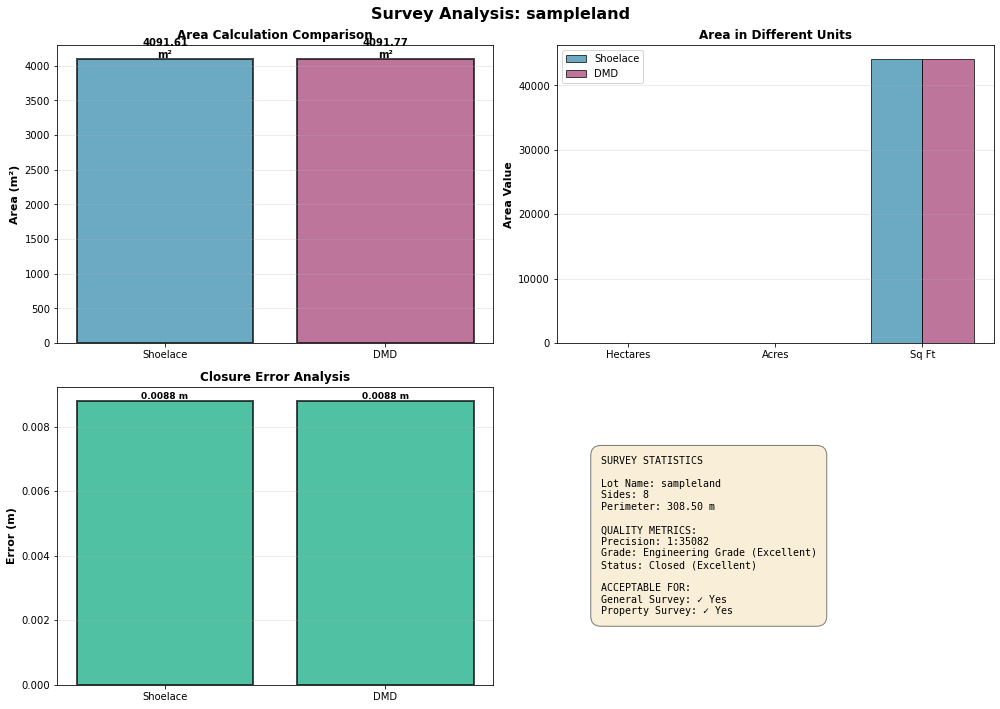


✓ Visualization complete


In [14]:
if is_valid:
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Survey Analysis: {lot_name}', fontsize=16, fontweight='bold')

    # 1. Area comparison
    ax1 = axes[0, 0]
    methods = ['Shoelace', 'DMD']
    areas = [shoelace_result['area_m2'], dmd_result['area_m2']]
    colors = ['#2E86AB', '#A23B72']
    bars = ax1.bar(methods, areas, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Area (m²)', fontsize=11, fontweight='bold')
    ax1.set_title('Area Calculation Comparison', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar, area in zip(bars, areas):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{area:.2f}\nm²',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 2. Unit conversion comparison
    ax2 = axes[0, 1]
    units = ['Hectares', 'Acres', 'Sq Ft']
    shoelace_units = [
        shoelace_result['area_hectares'],
        shoelace_result['area_acres'],
        shoelace_result['area_sqft']
    ]
    dmd_units = [
        dmd_result['area_hectares'],
        dmd_result['area_acres'],
        dmd_result['area_sqft']
    ]
    x = np.arange(len(units))
    width = 0.35
    ax2.bar(x - width/2, shoelace_units, width, label='Shoelace', color='#2E86AB', alpha=0.7, edgecolor='black')
    ax2.bar(x + width/2, dmd_units, width, label='DMD', color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Area Value', fontsize=11, fontweight='bold')
    ax2.set_title('Area in Different Units', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(units)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. Closure error
    ax3 = axes[1, 0]
    closure_methods = ['Shoelace', 'DMD']
    closure_errors = [shoelace_result['closure_error_m'], dmd_result['closure_error_m']]
    colors_closure = ['#06A77D' if e < 0.1 else '#F18F01' for e in closure_errors]
    bars3 = ax3.bar(closure_methods, closure_errors, color=colors_closure, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Error (m)', fontsize=11, fontweight='bold')
    ax3.set_title('Closure Error Analysis', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    for bar, error in zip(bars3, closure_errors):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.4f} m',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 4. Survey statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    gen_ok = '✓ Yes' if shoelace_result['acceptable_general'] else '✗ No'
    prop_ok = '✓ Yes' if shoelace_result['acceptable_property'] else '✗ No'
    stats_text = f'''SURVEY STATISTICS

Lot Name: {lot_name}
Sides: {shoelace_result["num_sides"]}
Perimeter: {shoelace_result["perimeter_m"]:.2f} m

QUALITY METRICS:
Precision: {shoelace_result["relative_precision"]}
Grade: {shoelace_result["precision_grade"]}
Status: {shoelace_result["closure_status"]}

ACCEPTABLE FOR:
General Survey: {gen_ok}
Property Survey: {prop_ok}'''
    ax4.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5, pad=1))

    plt.tight_layout()
    plt.show()

    print('\n✓ Visualization complete')

## 16. Polygon Visualization (Shoelace Method)

**What this does:**
- Creates a detailed polygon plot showing the survey area
- Displays vertices with coordinates
- Shows bearings and distances on each line
- Includes a north arrow for orientation
- Provides visual verification of the survey layout

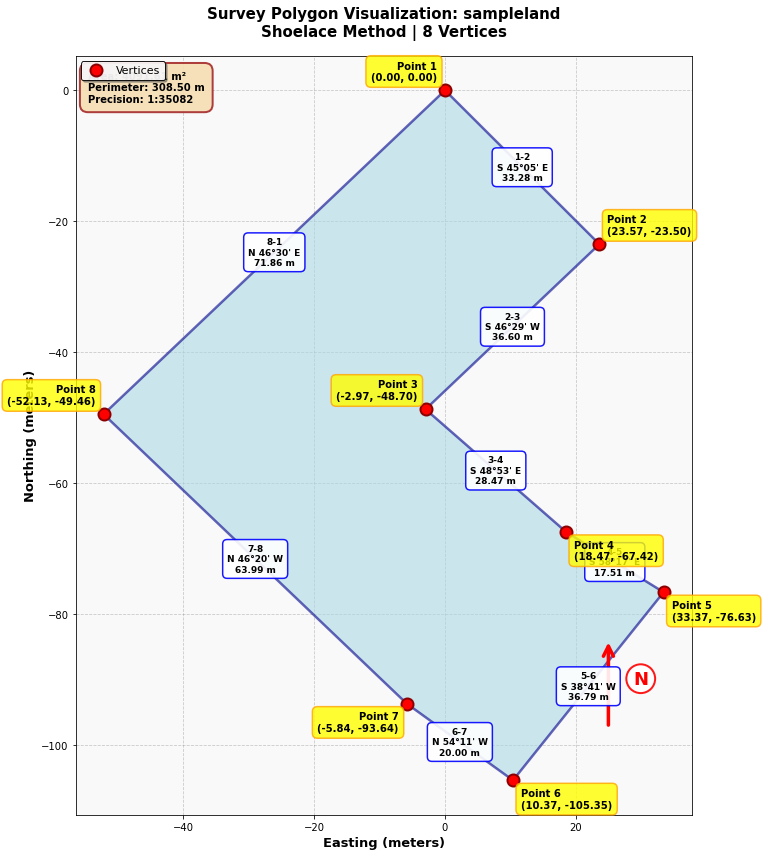


✓ Professional polygon visualization complete
  • 8 vertices plotted
  • 8 survey lines labeled
  • Area: 4091.61 m²


In [15]:
if is_valid:
    from matplotlib.patches import Polygon as PolygonPatch
    from matplotlib.patches import FancyArrowPatch
    
    # Create Shoelace calculator to get polygon coordinates
    shoelace_calc = ShoelaceCalculator()
    for bearing, distance in zip(bearings, distances):
        shoelace_calc.add_line(bearing, distance)
    shoelace_calc.calculate_coordinates()
    
    # Extract coordinates
    x_coords = [p.x for p in shoelace_calc.points]
    y_coords = [p.y for p in shoelace_calc.points]
    
    # Calculate polygon extent for better scaling
    x_range = max(x_coords) - min(x_coords)
    y_range = max(y_coords) - min(y_coords)
    max_range = max(x_range, y_range)
    
    # Create figure with professional styling
    fig, ax = plt.subplots(figsize=(14, 12))
    fig.patch.set_facecolor('white')
    
    # Plot the polygon with professional styling
    polygon = PolygonPatch(
        list(zip(x_coords, y_coords)),
        fill=True,
        facecolor='lightblue',
        edgecolor='darkblue',
        linewidth=2.5,
        alpha=0.6,
        zorder=1
    )
    ax.add_patch(polygon)
    
    # Plot vertices with larger, more visible markers
    ax.plot(x_coords, y_coords, 'ro', markersize=12, zorder=5, 
            label='Vertices', markeredgecolor='darkred', markeredgewidth=2)
    
    # Add point labels with coordinates (improved positioning)
    point_labels = [str(i) for i in range(1, len(x_coords) + 1)]
    for i, (x, y, label) in enumerate(zip(x_coords, y_coords, point_labels)):
        # Smart offset based on position relative to center
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        offset_x = 8 if x > center_x else -8
        offset_y = 8 if y > center_y else -8
        
        ax.annotate(
            f'Point {label}\n({x:.2f}, {y:.2f})',
            xy=(x, y),
            xytext=(offset_x, offset_y),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                     alpha=0.8, edgecolor='orange', linewidth=1.5),
            ha='left' if x > center_x else 'right',
            va='bottom' if y > center_y else 'top',
            zorder=6
        )
    
    # Add line labels with bearing, distance, and line number
    line_labels = [f'{i+1}-{(i+1)%len(x_coords)+1 if (i+1)%len(x_coords) != 0 else 1}' 
                  for i in range(len(x_coords))]
    
    for i in range(len(x_coords)):
        j = (i + 1) % len(x_coords)
        mid_x = (x_coords[i] + x_coords[j]) / 2
        mid_y = (y_coords[i] + y_coords[j]) / 2
        
        # Format label with line number, bearing, and distance
        label_text = (f'{line_labels[i]}\n'
                     f'{shoelace_calc.lines[i].bearing}\n'
                     f'{shoelace_calc.lines[i].distance:.2f} m')
        
        ax.annotate(
            label_text,
            xy=(mid_x, mid_y),
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='blue', alpha=0.9, linewidth=1.5),
            ha='center',
            va='center',
            zorder=4
        )
    
    # Add professional north arrow
    arrow_length = max_range * 0.12
    arrow_x = max(x_coords) - max_range * 0.08
    arrow_y = min(y_coords) + max_range * 0.08
    
    # Draw arrow shaft
    ax.annotate(
        '', 
        xy=(arrow_x, arrow_y + arrow_length),
        xytext=(arrow_x, arrow_y),
        arrowprops=dict(arrowstyle='->', lw=3.5, color='red', 
                       mutation_scale=25, shrinkA=0, shrinkB=0)
    )
    
    # Add 'N' label
    ax.text(arrow_x + arrow_length * 0.3, arrow_y + arrow_length * 0.5, 'N',
            fontsize=18, fontweight='bold', color='red',
            bbox=dict(boxstyle='circle', facecolor='white', 
                     edgecolor='red', linewidth=2, alpha=0.9))
    
    # Calculate and display area on plot
    area_text = (f'Area: {shoelace_result["area_m2"]:.2f} m²\n'
                f'Perimeter: {shoelace_result["perimeter_m"]:.2f} m\n'
                f'Precision: {shoelace_result["relative_precision"]}')
    
    ax.text(0.02, 0.98, area_text,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='wheat', 
                     alpha=0.9, edgecolor='brown', linewidth=2))
    
    # Professional axis styling
    ax.set_xlabel('Easting (meters)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Northing (meters)', fontsize=13, fontweight='bold')
    ax.set_title(f'Survey Polygon Visualization: {lot_name}\n'
                f'Shoelace Method | {len(x_coords)} Vertices',
                fontsize=15, fontweight='bold', pad=20)
    
    # Grid styling
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax.set_axisbelow(True)
    
    # Equal aspect ratio for accurate representation
    ax.set_aspect('equal', adjustable='box')
    
    # Add subtle background color
    ax.set_facecolor('#f9f9f9')
    
    # Legend
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9, 
             edgecolor='black', fancybox=True, shadow=True)
    
    # Add closure error info if significant
    if shoelace_result['closure_error_m'] > 0.01:
        closure_text = f'Closure Error: {shoelace_result["closure_error_m"]:.4f} m'
        ax.text(0.98, 0.02, closure_text,
                transform=ax.transAxes,
                fontsize=9,
                style='italic',
                horizontalalignment='right',
                verticalalignment='bottom',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                         alpha=0.8, edgecolor='orange'))
    
    plt.tight_layout()
    plt.show()
    
    print('\n✓ Professional polygon visualization complete')
    print(f'  • {len(x_coords)} vertices plotted')
    print(f'  • {len(shoelace_calc.lines)} survey lines labeled')
    print(f'  • Area: {shoelace_result["area_m2"]:.2f} m²')

## 17. Input Data Reference

**What this does:**
- Displays the original input data for documentation
- Shows the bearings and distances used in calculations

In [16]:
if is_valid:
    print('\nINPUT DATA SUMMARY:')
    print('=' * 80)
    print(df.to_string(index=False))


INPUT DATA SUMMARY:
Lines   Bearings  Distances
  1-2 S 45°05' E      33.28
  2-3 S 46°29' W      36.60
  3-4 S 48°53' E      28.47
  4-5 S 58°17' E      17.51
  5-6 S 38°41' W      36.79
  6-7 N 54°11' W      20.00
  7-8 N 46°20' W      63.99
  8-1 N 46°30' E      71.86
